# Technical Analysis of SilverCorp Metals

Today we will be analyzing SilverCorp Metals listed as SVM on the Toronto Stock Exchange.

## Table of Contents
***
* [Relative Strength Index](#RSI)
* [Volatility](#vol)
* [Beta](#beta)
* [Moving Average Convergence/Divergence](#macd)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_datareader.data as web
import datetime

plt.style.use('seaborn')

First we will grab the data for SVM from Yahoo Finance. The dataframe that we get from Yahoo has the following features Open, Close, Adjusted Close, High, Low and Volume. Note that we are using the TSX listed version of SVM not the NYSE version.

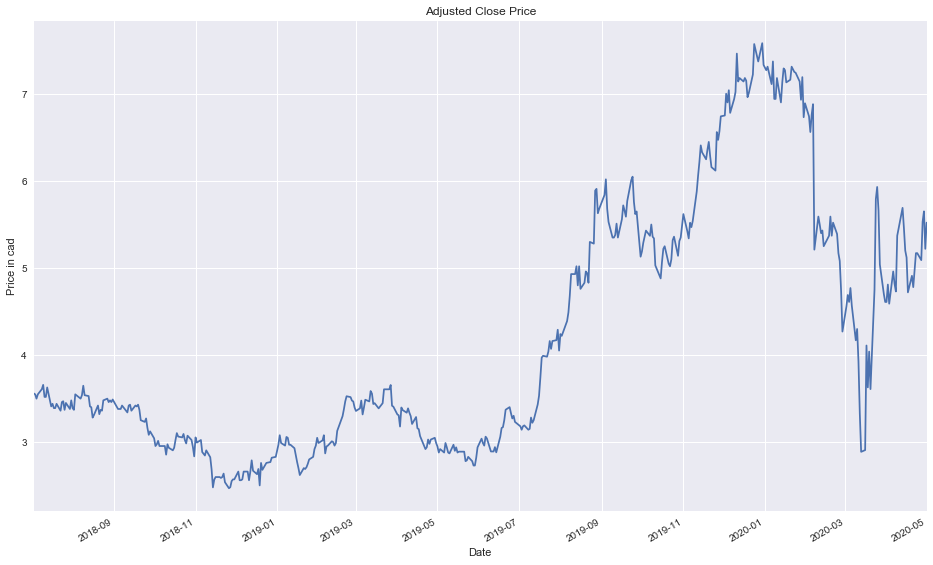

In [2]:
start = datetime.datetime(2018, 7, 1)
end = datetime.datetime(2020, 5, 2)

svm = web.DataReader('SVM.TO', 'yahoo', start, end)

svm['Adj Close'].plot(figsize=(16,10), title='Adjusted Close Price')
plt.ylabel('Price in cad');

## Relative Strength Index
<a id="rsi"></a>

Relative strength index (or RSI) is momentum indicator, that compares the magnitude of gains and losses over a certain time period to measure speed and changes of price movements. RSI is a value between 0-100, where a stock with a RSI value below 30 is considered oversold and a value above 70 is considered overbought and indicates that a reversal may occur.

RSI is calculated as $RSI=100- \frac{100}{(1+RS)}$


Where $RS=\frac{Average\:gain\:over\:last\:14\:days}{Average\:loss\:over\:14\: days}$

In [3]:
period = 14

delta = svm['Adj Close'].diff()

#Replace negative and postive values with zeros
up = delta.mask(delta < 0, 0)
down = delta.mask(delta > 0, 0)

svm['Gain'] = up
svm['Loss'] = down

avg_gain = up.ewm(com = period-1, min_periods = period).mean()
avg_loss = down.ewm(com = period-1, min_periods = period).mean()

svm['Avg_Gain'] = avg_gain
svm['Avg_Loss'] = avg_loss

rs = abs(avg_gain/avg_loss)
rsi = 100 - (100 / (1+rs))

rsi.tail()

Date
2020-04-27    51.896072
2020-04-28    57.694524
2020-04-29    59.141067
2020-04-30    52.247095
2020-05-01    56.092618
Name: Adj Close, dtype: float64

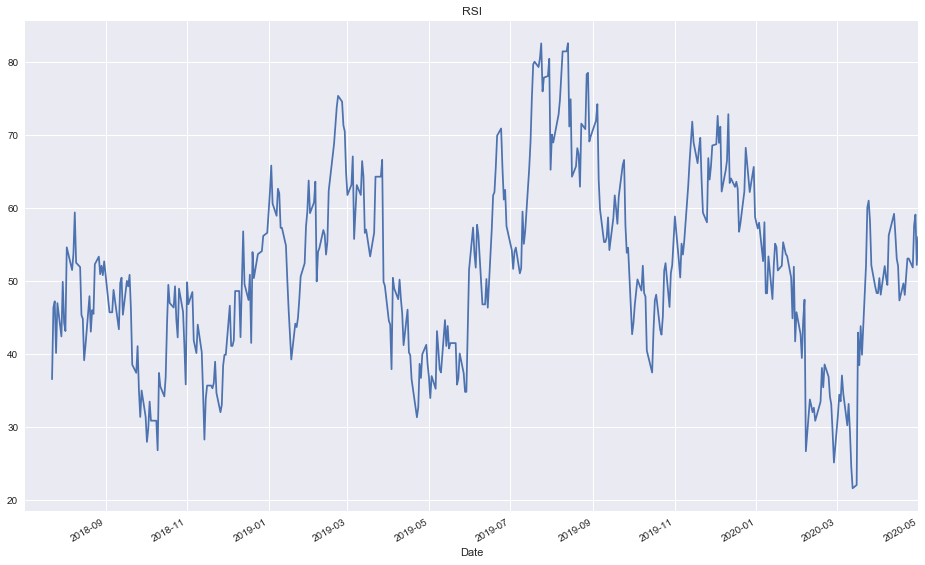

In [4]:
rsi.plot(figsize=(16,10), title='RSI');

## Volatility
<a id="vol"></a>

Volatility is the measure of the dispersion of returns for a stock. A stock with a high volatility is more likely to reach new highs and lows more often than a stock with a low volatility, this can make a stock more risky but its not necessarily bad to have a high volatilty. 

Volatility is typically calculated using the standard deviation or the variance in the percent change in price. We will be using the stanard deviation calculation. Python does have a built-in var() function that will calculate the variance for us, but lets calculate on our own using the the equation for Standard deviation,

$\large S^2 = \frac{\sum\:(x\:-\:\bar{x})}{n\:-\:1}$

In [5]:
svm_chg = svm['Adj Close'].pct_change().apply(lambda x: np.log(1+x))

mean_svm  = svm_chg.sum() / svm_chg.count()
numerator = svm_chg.apply(lambda x: ((x-mean_svm)**2))
numerator = numerator.sum()
var_svm = numerator / (svm_chg.count() - 1)

print("Volatility using our method {:.4f}".format(np.sqrt(var_svm)))
print("Volatility using Python's var() method {:.4f}".format(np.sqrt(svm_chg.var())))

Volatility using our method 0.0435
Volatility using Python's var() method 0.0435


## Beta
<a id="beta"></a>

Beta is a stock volatility compared to the volatility of the market or a major index. The market is said to have a beta value of 1.00, so a stock with a beta value larger than 1 is more volatile than the market and a value less than 1 is said to be less volatile than the market. 

Beta is calculated as $\large\beta = \frac {cov\,(R_s,\:R_m)}{var\,(R_m)}$ = $\large\frac{\sum\:(R_s\:-\:\bar{R_s})\:*\:(R_m\:-\:\bar{R_m})}{N\:-\:1}$

Where $R_s$ is the daily return on adjusted close on the stock we are calculating beta for and $R_m$ is the daily return on adjusted close from the market. N is the total population size or just the period of time we are calculating beta for.

We will being comparing SVM to S&P/TSX which is the major index for the TSX. Once again we will grab our data from Yahoo Finance.

In [6]:
tsx = web.DataReader('^GSPTSE', 'yahoo', start, end)
tsx.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-07-03,16346.099609,16227.299805,16332.400391,16263.200195,167706400,16263.200195
2018-07-04,16330.700195,16260.299805,16272.400391,16304.700195,63098400,16304.700195
2018-07-05,16330.900391,16235.599609,16326.900391,16266.599609,169774100,16266.599609
2018-07-06,16378.599609,16230.299805,16242.400391,16371.799805,141594800,16371.799805
2018-07-09,16460.500000,16382.299805,16402.699219,16452.300781,149277900,16452.300781


Both Pandas and NumPy have built-in covariance functions, but we will calculate ours from scratch using the equation above

In [40]:
#Calculate the covariance between SVM and S&P/TSX 
svm_chg = svm['Adj Close'].pct_change().apply(lambda x: np.log(1+x))
tsx_chg = tsx['Adj Close'].pct_change().apply(lambda x: np.log(1+x))

mean_svm = svm_chg.mean()
mean_tsx = tsx_chg.mean()

expected_svm = svm_chg.apply(lambda x: (x - mean_svm)) 
expected_tsx = tsx_chg.apply(lambda x: (x - mean_tsx))
cov = expected_svm * expected_tsx
cov = cov.sum() / (cov.count() - 1)

print("Our Covariance between SVM and S&P/TSX is {:.4f}".format(cov))

Our Covariance between SVM and S&P/TSX is 0.0002


In [38]:
#Calculate variance of tsx using the method from before
tsx_chg = tsx['Adj Close'].pct_change().apply(lambda x: np.log(1+x))
mean_tsx  = tsx_chg.sum() / tsx_chg.count()
numerator = tsx_chg.apply(lambda x: ((x-mean_tsx)**2))
numerator = numerator.sum()
var_tsx = numerator / (tsx_chg.count() - 1)

print("TSX has a variance of {:.5f}".format(var_tsx))

TSX has a variance of 0.00024


In [37]:
#Now calculate beta
beta = cov/var_tsx
print("SVM has a beta value of {:.2f}, indicating that it is less volatile then S&P/TSX".format(beta))

SVM has a beta value of 0.74, indicating that it is less volatile then S&P/TSX
